# Notebook to generate psychometrics plot given sessions & conditions

In [37]:
import datajoint as dj
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.optimize import curve_fit
from astropy.stats import binom_conf_interval
import datetime

### Datajoint configuration

In [2]:
dj.config['database.host'] = 'datajoint00.pni.princeton.edu'
dj.config['enable_python_native_blobs'] = True

dj.config['stores'] = {
    'extstorage':
    {
        'location': '/Volumes/u19_dj/external_dj_blobs',
        'protocol': 'file'
    }
}

### Connection to DB

In [3]:
dj.conn()
behavior = dj.create_virtual_module('subject', 'u19_behavior')

Please enter DataJoint username: alvaros
Please enter DataJoint password: ········
Connecting alvaros@datajoint00.pni.princeton.edu:3306


### Sigmoid function definition

In [4]:
def psychometrics_function(x, O, A, lambd, x0):
    return O + A/(1+np.exp(-(x-x0)/lambd))

### Function to fit eveidence & choices to the sigmoid function (from SueAnn's original Matlab function)

In [50]:
def psychFit(deltaBins, numR, numL, choices):

    numRight            = np.zeros(len(deltaBins))
    numTrials           = np.zeros(len(deltaBins))
    trialDelta          = np.zeros(len(deltaBins))
    phat                = np.zeros(len(deltaBins))
    pci                 = np.zeros((2, len(deltaBins)))
    
    #Evidence variable
    nCues_RminusL       = numR - numL
    #Correct deltaBin & trialBin to produce same result as Matlab psychFit
    deltaBins_search =  deltaBins.astype(float) - 1.5
    trialBin = np.searchsorted(deltaBins_search, nCues_RminusL, side='right')
    trialBin -= 1;
    
    #Put into evidence bins all Trials with corresponding choices
    for iTrial in range(len(choices)):
        numTrials[trialBin[iTrial]]   = numTrials[trialBin[iTrial]] + 1
        if choices[iTrial] == 2:
            numRight[trialBin[iTrial]]  = numRight[trialBin[iTrial]] + 1
            
        trialDelta[trialBin[iTrial]]  = trialDelta[trialBin[iTrial]] + nCues_RminusL[iTrial]
      
    with np.errstate(divide='ignore', invalid='ignore'):
        trialDelta          = np.true_divide(trialDelta, numTrials);
    
    # Select only bins with trials
    idx_zero = numTrials == 0    
    numTrials_nz = numTrials[~idx_zero]
    numRight_nz  = numRight[~idx_zero]
        
    #(Binomial proportion confidence interval given k successes, n trials)
    phat_nz = binom_conf_interval(numRight_nz, numTrials_nz, confidence_level=0, interval='jeffreys')
    pci_nz  = binom_conf_interval(numRight_nz, numTrials_nz, confidence_level=1-0.1587, interval='jeffreys')
    
    #Correct confidence intervals and expected outcomes for bins with no trials (ci = [0 1], hat = 0.5)
    phat_nz = phat_nz[0]
    phat[~idx_zero] = phat_nz
    phat[idx_zero]  = 0.5
    pci[0][~idx_zero] = pci_nz[0]
    pci[0][idx_zero]  = 0
    pci[1][~idx_zero] = pci_nz[1]
    pci[1][idx_zero]  = 1
    
    # (Logistic function fit) only valid if we have at least 5 bins with trials
    if np.count_nonzero(~idx_zero) < 5:
        is_there_psychometric = False
    else:
        is_there_psychometric = True
        #Get weight matrix to "reproduce" Matlab fit 
        #https://stackoverflow.com/questions/58983113/scipy-curve-fit-vs-matlab-fit-weighted-nonlinear-least-squares
        # matlab -> 'Weights'         , ((pci(sel,2) - pci(sel,1))/2).^-2 
        # python -> sigma = diagonal_matrix(1/weights)
        
        weight_array = np.power((pci[1][~idx_zero] - pci[0][~idx_zero])/2,2)
        sigma_fit    = np.diag(weight_array)
        
        psychometric, pcov = curve_fit(psychometrics_function, deltaBins[~idx_zero], phat[~idx_zero], \
                                          p0 = (0, 1, 3, 0),sigma = sigma_fit, maxfev=40000)

    #Append a row of nans to confidence intervals . whyy ??
    aux_vec = np.empty((1,pci.shape[1]))
    aux_vec[:] = np.nan
    pci = np.vstack((pci, aux_vec))
    
    # x vector for plotting
    delta      = np.linspace(deltaBins[0]-2, deltaBins[-1]+2, num=50)

    # Repeat trialDelta 3 times for errorX why ??
    errorX = np.tile(trialDelta[~idx_zero], 3);
    
    # Confidence intervals are errorY, as a vector
    errorY = np.stack(pci[:,~idx_zero])
    errorY = errorY.flatten()
    
    # Fill  dictionary of results
    fit_results = dict()
    fit_results['delta_bins']   = deltaBins[~idx_zero]
    fit_results['delta_data']   = trialDelta[~idx_zero];
    fit_results['pright_data']  = 100*phat[~idx_zero];
    fit_results['delta_error']  = errorX;
    fit_results['pright_error'] = 100*errorY;
    
    if is_there_psychometric:
        fit_results['delta_fit']  = delta
        fit_results['pright_fit'] = psychometrics_function(delta, *psychometric)*100
    else:
        fit_results['delta_fit']  = np.empty([0])
        fit_results['pright_fit'] = np.empty([0])
    
    return fit_results


### Session selection (to change in the future, select subjects and conditions)

In [45]:
keys = [{
    'subject_fullname': 'ms81_M005',
    'session_date': datetime.date(2021, 5, 8),
    'session_number': 0
}, {
    'subject_fullname': 'ms81_M004',
    'session_date': datetime.date(2021, 5, 8),
    'session_number': 0
}, {
    'subject_fullname': 'ms81_M004',
    'session_date': datetime.date(2021, 5, 7),
    'session_number': 0
}, {
    'subject_fullname': 'ms81_M003',
    'session_date': datetime.date(2021, 5, 7),
    'session_number': 0
}, {
    'subject_fullname': 'ms81_M004',
    'session_date': datetime.date(2021, 5, 6),
    'session_number': 0
},  {
    'subject_fullname': 'ms81_M005',
    'session_date': datetime.date(2021, 5, 5),
    'session_number': 0
}, {
    'subject_fullname': 'ms81_M002',
    'session_date': datetime.date(2021, 5, 3),
    'session_number': 0
}]

#List of colors
colors = ['r', 'y', 'k', 'b']

#Assign a color to each subject
keys_df = pd.DataFrame(keys)
subjects = keys_df.subject_fullname.unique()
subjects.sort()
zip_iterator = zip(subjects, colors)
color_dict = dict(zip_iterator)

#Create a color patch for plot legend
patches_legend = []
for key in color_dict:
    patches_legend.append(mpatches.Patch(color=color_dict[key], label=key))



### Select bins for evidence data (automate this step ??)

In [28]:
deltaBins = np.arange(-12, 13, step=3)
deltaBins

array([-12,  -9,  -6,  -3,   0,   3,   6,   9,  12])

### Fit all sessions to sigmoid and plot

/Users/alvaros/Documents/MATLAB/BrainCogsProjects/Datajoint_proj/U19-pipeline_python/venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


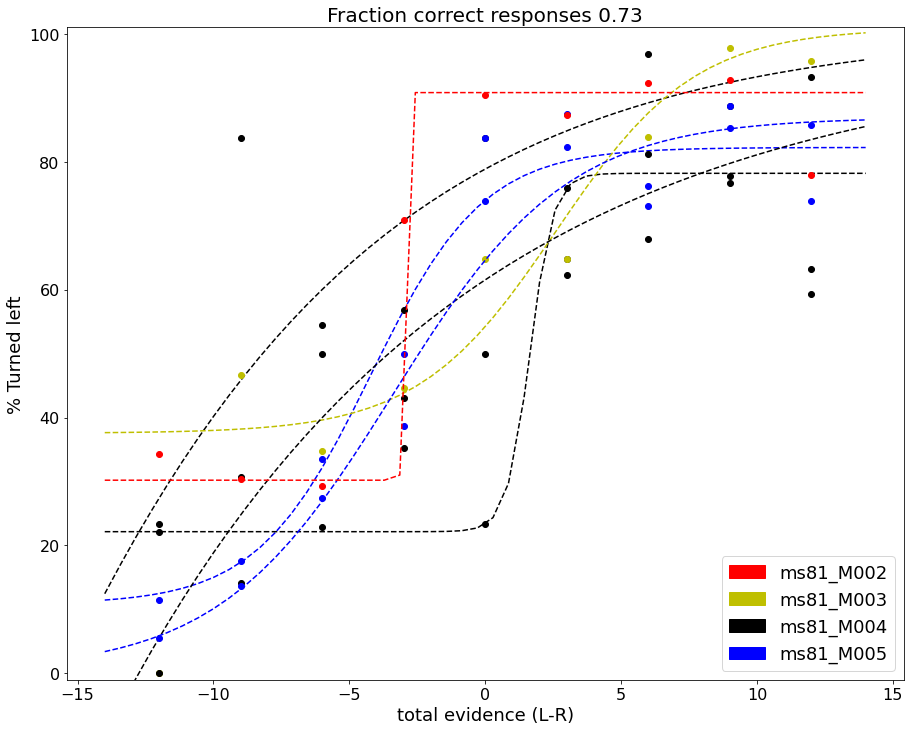

In [54]:

plt.figure(figsize=(15, 12))
fraction_correct = np.zeros(len(keys))
for key_idx, key in enumerate(keys):

    key_spec = behavior.TowersBlock() & key & "level = 11" & "block_performance > 0.65"
    thissession = behavior.TowersBlock().Trial() & key_spec
    
    # Fetch session
    session_info = pd.DataFrame(thissession.fetch('choice', 'trial_type', 'cue_presence_left', 'cue_presence_right', as_dict=True))
    
    # Choice and trial type as integer
    session_info['trial_type_int'] = 0
    session_info.loc[session_info['trial_type'] == 'L','trial_type_int'] = 1 
    session_info.loc[session_info['trial_type'] == 'R','trial_type_int'] = 2 
    session_info['choice_int'] = 0
    session_info.loc[session_info['choice'] == 'L','choice_int'] = 1 
    session_info.loc[session_info['choice'] == 'R','choice_int'] = 2
    
    # number of towers per trial
    session_info['cue_presence_left'] = session_info['cue_presence_left'].apply(lambda x: np.count_nonzero(x))
    session_info['cue_presence_right'] = session_info['cue_presence_right'].apply(lambda x: np.count_nonzero(x))
    
    
    fraction_correct[key_idx] = np.sum(session_info['choice'].values == session_info['trial_type'].values)/session_info.shape[0]
    
    # Call Fit to sigmoid function
    fit_dict = psychFit(deltaBins, session_info['cue_presence_right'].values, \
                        session_info['cue_presence_left'].values, session_info['choice_int'].values)
    
    #Select color from color dictionary
    color_plot = color_dict[key['subject_fullname']]
    #Plot results
    plt.plot(fit_dict['delta_bins'], fit_dict['pright_data'], 'o', color = color_plot)
    if fit_dict['delta_fit'].shape[0] > 0:
        plt.plot(fit_dict['delta_fit'], fit_dict['pright_fit'], '--', color = color_plot)
        
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("total evidence (L-R)", fontsize=18)
plt.ylabel("% Turned left", fontsize=18)
plt.ylim([-1, 101])
#pl.xlim([-11,11])
mean_correct_string = f"{np.mean(fraction_correct):2.2f}"
plt.title('Fraction correct responses '+mean_correct_string, fontsize=20)
plt.legend(handles=patches_legend, fontsize=18)
print()